In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import h5py
import pickle
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from src.data.file_utils import GetTV
from src.models import model, predict

In [3]:
models = predict.list_models()
for idx, model in enumerate(models):
    print(idx, model)

0 ../models/lr_tv_inv_outer.pkl
1 ../models/lr_inversion_manual.pkl
2 ../models/lr_intercept.txt
3 ../models/lr_coef.txt
4 ../models/.gitignore
5 ../models/lr_supervised_mdl.pkl


In [4]:
prep_filename = 'tv_inv_outer'
prediction_filename = 'lr'
algorithm = 'linear'
inversion_to_point_model_index = 5
split_ratio = 0.2

In [5]:
tv_path = Path('../data/raw/tv_images/l-mode')
label_path = Path('../data/processed/inversion_data')
prep_path = Path('../data/processed/hdf5')
model_path = Path('../models')

# Data Prep

In [6]:
tv = GetTV(tv_path)
files = tv.list_files()
file_lengths = tv.file_lengths()
cumulative_lengths = np.insert(np.cumsum(file_lengths), 0, 0)
tv_dim = tv.load(files[0], 'vid').shape
inversion_dim = tv.load(files[0], 'inverted').shape

In [7]:
def file_split_compile_prep(split_ratio,
                      prep_path,
                      prep_filename,
                      files):
    # split by file
    train_files, test_files = train_test_split(files, test_size=split_ratio, random_state=30)
    [print(file.stem) for file in train_files]
    print('-------------------')
    [print(file.stem) for file in test_files]

    points_train = []
    tv_train = []
    inverted_train = []
    points_test = []
    tv_test = []
    inverted_test = []
    
    with open(models[inversion_to_point_model_index], 'rb') as f:
        inversion_model = pickle.load(f)

    for _, file in enumerate(train_files):
        frames = tv.load(file, 'frames').astype('int')
        tv_image = tv.load(file, 'vid')[frames]
        inversion = tv.load(file, 'inverted')
        inversion_vid2 = inversion.reshape((len(inversion), -1))
        for i in range(len(frames)):
            tv_train.append(tv_image[i])
            inverted_train.append(inversion[i])
            points_train.append(inversion_model.predict(inversion_vid2[i].reshape(1, -1)))
            
    for _, file in enumerate(test_files):
        frames = tv.load(file, 'frames').astype('int')
        tv_image = tv.load(file, 'vid')[frames]
        inversion = tv.load(file, 'inverted')
        inversion_vid2 = inversion.reshape((len(inversion), -1))
        for i in range(len(frames)):
            tv_test.append(tv_image[i])
            inverted_test.append(inversion[i])
            points_test.append(inversion_model.predict(inversion_vid2[i].reshape(1, -1)))
            
    with h5py.File(prep_path / str(prep_filename + '.h5'), 'w') as f:
        f.create_dataset('vid_train', data=tv_train)
        f.create_dataset('inverted_train', data=inverted_train)
        f.create_dataset('points_train', data=points_train)
        f.create_dataset('vid_test', data=tv_test)
        f.create_dataset('inverted_test', data=inverted_test)
        f.create_dataset('points_test', data=points_test)
    print(str(prep_path / str(prep_filename + '.h5')),'has been saved!')

In [8]:
file_split_compile_prep(split_ratio, prep_path, prep_filename, files)

emission_structure_pu_cam240perp_190109
emission_structure_pu_cam240perp_190113
emission_structure_pu_cam240perp_190114
emission_structure_pu_cam240perp_190116
-------------------
emission_structure_pu_cam240perp_190115
emission_structure_pu_cam240perp_190110
../data/processed/hdf5/tv_inv_outer.h5 has been saved!


# Train Test Deploy

### Train

In [9]:
file_name = prep_filename + '.h5'

with h5py.File(prep_path / file_name, 'r') as f:
    vid_train = f['vid_train'][:]
    inverted_train = f['inverted_train'][:]
    points_train = f['points_train'][:]
    vid_test = f['vid_test'][:]
    inverted_test = f['inverted_test'][:]
    points_test = f['points_test'][:]

files = tv.list_files()
elevation = tv.load(files[0], 'elevation')[0]
radii = tv.load(files[0], 'radii')[0]
vid_shape = tv.load(files[0], 'vid')[0].shape

In [10]:
X_train = vid_train.reshape((len(vid_train), -1))
X_test = vid_test.reshape((len(vid_test), -1))
y_train = points_train.reshape((len(points_train), -1))
y_test = points_test.reshape((len(points_test), -1))

In [20]:
mdl = LinearRegression()
mdl.fit(X_train, y_train)

LinearRegression()

### Test

In [21]:
r_sq = mdl.score(X_test, y_test)
r_predict = mdl.predict(X_test)
real_predict = np.array([radii[np.round(r_predict[:,0]).astype(int)],elevation[np.round(r_predict[:,1]).astype(int)]]).T
real_y = np.array([radii[np.round(y_test[:,0]).astype(int)],elevation[np.round(y_test[:,1]).astype(int)]]).T
print(r_sq)
print(f"RMS (cm) : {np.sqrt(mean_squared_error(real_predict, real_y)*100)}")

0.9137808812444588
RMS (cm) : 0.079584501683712


### Deploy

In [22]:
coef = mdl.coef_
intercept = mdl.intercept_
with open(model_path / 'lr_coef.txt', 'w') as f:
    for i in range(coef.shape[1]):
        f.write(str(coef[0][i]) + '\n')
    for i in range(coef.shape[1]):
        f.write(str(coef[1][i]) + '\n')

with open(model_path / 'lr_intercept.txt', 'w') as f:
    for i in range(intercept.shape[0]):
        f.write(str(intercept[i]) + '\n')

In [11]:
mdl_path = "../models/lr_coef.txt"  # Replace with your file path

with open(mdl_path, "r") as file:
    coef = file.readlines()

mdl_path = "../models/lr_intercept.txt"  # Replace with your file path

with open(mdl_path, "r") as file:
    inter = file.readlines()
    
coef_ = np.array([float(i) for i in coef])
inter_ = np.array([float(i) for i in inter])
r_coef_ = coef_[:len(coef_)//2]
z_coef_ = coef_[len(coef_)//2:]

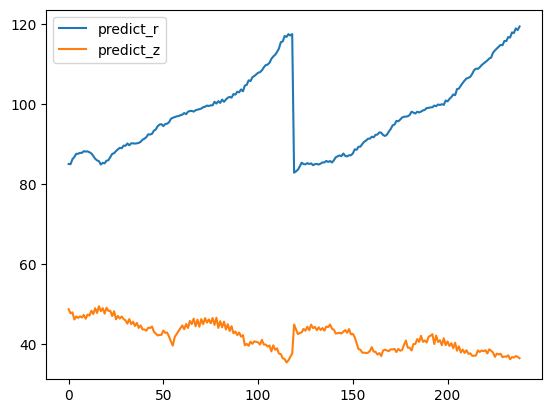

In [13]:
# example index 1
pred_r = np.dot(X_test, r_coef_) + inter_[0] # left half
pred_z = np.dot(X_test, z_coef_) + inter_[1] # right half
plt.plot(pred_r, label='predict_r')
plt.plot(pred_z, label='predict_z')
plt.legend()
plt.show()

# Downsample Tests

In [16]:
# downsampling functions
downsample2d = lambda x, factor : x[:, ::factor, ::factor]
flatten = lambda x : x.reshape(len(x), -1)

def regr_scoring(X_train, X_test, y_train, y_test):
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    r_predict = regr.predict(X_test)
    real_predict = np.array([radii[np.round(r_predict[:,0]).astype(int)],elevation[np.round(r_predict[:,1]).astype(int)]]).T * 100 # from meter to cm (dimension is n x 2)
    real_y = np.array([radii[np.round(y_test[:,0]).astype(int)],elevation[np.round(y_test[:,1]).astype(int)]]).T * 100
    dist = np.linalg.norm(real_predict - real_y, axis=1)
    z_err = np.abs(real_predict[:,1] - real_y[:,1])
    return r_predict, dist, z_err

In [19]:
downsamples = range(1,10)
numpixel_array = []
r_sq_array = []
rms_array = []
rms_z_err_array = []

for n in downsamples:
    print(n)
    vid_train_down = downsample2d(vid_train, n)
    vid_test_down = downsample2d(vid_test, n)
    
    vid_train_down_reshape = flatten(vid_train_down)
    vid_test_down_reshape = flatten(vid_test_down)
    points_train_reshape = flatten(points_train)
    points_test_reshape = flatten(points_test)
    
    numpixel = vid_train_down_reshape.shape[1]
    
    _, dist, z_err = regr_scoring(vid_train_down_reshape, vid_test_down_reshape, points_train_reshape, points_test_reshape)
    
    numpixel_array.append(numpixel)
    r_sq_array.append(r_sq)
    rms_array.append(np.sqrt(np.square(dist).mean()))
    rms_z_err_array.append(np.sqrt(np.square(z_err).mean()))

1
